In [237]:
import warnings

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from glmnet import glmnet
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

warnings.filterwarnings("ignore")

# Logistic regression with different regularizations: lasso, ridge, elastic net

## Load dataset

In [238]:
df_x = pd.read_csv("data/prostate_x.txt", sep=" ")
df_y = pd.read_csv("data/prostate_y.txt", sep=" ")
df = df_x
df["y"] = df_y["x"]

print(f"Shape of dataset: {df.shape}")
print("Head of dataset:")
df.head()

Shape of dataset: (102, 6034)
Head of dataset:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V6025,V6026,V6027,V6028,V6029,V6030,V6031,V6032,V6033,y
1,-0.927178,-0.740039,-0.532016,-1.097891,-0.986673,0.018752,-0.863326,3.959997,-0.398219,-1.097891,...,-1.097891,-1.097891,-0.894733,0.850270,-1.097891,-0.302063,-0.767685,-0.452616,0.194001,0
2,-0.835899,-0.835899,-0.585647,-0.835899,-0.329768,-0.835899,-0.835899,4.037788,-0.835899,-0.835899,...,-0.835899,-0.835899,-0.835899,0.038090,-0.835899,-0.835899,-0.835899,-0.835899,0.075500,0
3,0.236073,0.252645,-1.154351,-0.372372,-0.338900,1.253467,0.506325,3.868961,0.201932,-1.154351,...,-1.154351,-1.154351,-0.372372,0.899781,-0.867200,0.360426,-1.154351,-1.154351,-1.154351,0
4,-0.748623,-0.439165,0.790953,-1.033876,0.241115,1.216007,0.106282,3.976272,0.081755,-1.121534,...,-1.121534,-1.121534,-0.812076,1.230378,-0.355497,0.030647,-0.278810,-1.121534,-1.121534,0
5,0.101239,-0.298285,-1.121519,-0.957714,0.342258,1.182937,0.029325,4.575871,-0.196466,-1.121519,...,-1.121519,-1.121519,-0.454932,0.891627,-0.593427,0.306316,-0.076496,-0.134480,-1.121519,0


## Fit model

In [239]:
X = df.drop(columns=["y"], axis=1)
y = df["y"]

In [240]:
Cs= np.arange(0.1, 1.1, step=0.1)
output_l1 = []
output_l2 = []
output_both = []

for c in Cs:
    lr_l1 = LogisticRegression(penalty="l1", solver="saga", C=c, max_iter=500)
    lr_l2 = LogisticRegression(penalty="l2", solver="saga", C=c, max_iter=500)
    lr_both = LogisticRegression(penalty="elasticnet", solver="saga", C=c, l1_ratio=0.5, max_iter=500)

    lr_l1.fit(X, y)
    lr_l2.fit(X, y)
    lr_both.fit(X, y)

    output_l1.append(lr_l1.coef_.ravel())
    output_l2.append(lr_l2.coef_.ravel())
    output_both.append(lr_both.coef_.ravel())


## Value of some coefficients depending on lambda

In [241]:
matrix_coef = np.concatenate([np.array([Cs]).T, np.abs(np.array(output_both))[:, [11, 12, 44, 106]]], axis=1)

coef_df = pd.DataFrame(
    matrix_coef,
    columns=["1 / lambda", "11", "12", "44", "192"],
)
coef_df = pd.melt(
    coef_df, 
    id_vars=["1 / lambda"], 
    value_vars=["11", "12", "44", "192"],
    var_name="coef",
    value_name="value",
)
coef_df.head()

,1 / lambda,coef,value
0,0.1,11,0.0
1,0.2,11,0.0
2,0.3,11,0.0
3,0.4,11,0.0
4,0.5,11,0.0


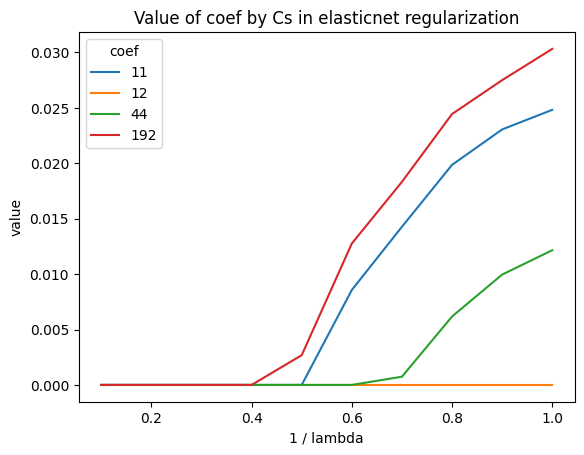

In [242]:
f, ax = plt.subplots(1, 1)

sns.lineplot(data=coef_df, x="1 / lambda", y="value", hue="coef")

plt.title("Value of coef by Cs in elasticnet regularization")

plt.show()

## Optimal value of lambda using cross-validation

In [243]:
Cs = np.arange(0.1, 10, step=0.1)

lr_l1_cv = LogisticRegressionCV(
    penalty="l1", 
    solver="saga", 
    max_iter=500, 
    Cs=Cs, 
    n_jobs=-1,
)
lr_l1_cv.fit(X, y)
print(f"Optimal 1 / lambda value for l1: {lr_l1_cv.C_}")

lr_l2_cv = LogisticRegressionCV(
    penalty="l2", 
    solver="saga", 
    max_iter=500, 
    Cs=Cs, 
    n_jobs=-1,
)
lr_l2_cv.fit(X, y)
print(f"Optimal 1 / lambda value for l2: {lr_l2_cv.C_}")

lr_both_cv = LogisticRegressionCV(
    penalty="elasticnet", 
    solver="saga", 
    max_iter=500, 
    Cs=Cs, 
    l1_ratios=np.array([0.5]), 
    n_jobs=-1,
)
lr_both_cv.fit(X, y)
print(f"Optimal 1 / lambda value for elasticnet: {lr_both_cv.C_}")

Optimal 1 / lambda value for l1: [9.2]
Optimal 1 / lambda value for l2: [0.1]
Optimal 1 / lambda value for elasticnet: [0.2]


# Performance of lasso for simulated data

#### Generation data from logistic model

In [244]:
def generate_data(n, n_relevant, n_irrelevant):
    betas = np.array(([1] * n_relevant) + ([0] * n_irrelevant))
    X = np.random.normal(size=(n, n_relevant + n_irrelevant), loc=0, scale=1)
    p = 1 / (1 + np.exp(np.sum(betas * X, axis=1)))
    y = np.random.binomial(n=1, p=p)

    return X, y

In [245]:
X, y = generate_data(100, 10, 10)

#### Selection of optimal lambda parameter

In [246]:
Cs = np.arange(0.1, 10, step=0.1)

lr = LogisticRegressionCV(
    penalty="l1", 
    solver="saga", 
    max_iter=500, 
    Cs=Cs,  
    n_jobs=-1,
)

lr.fit(X, y)
print(f"Optimal 1 / lambda value for l1: {lr.C_}")

Optimal 1 / lambda value for l1: [0.5]


#### Compute PSR and FDR

In [247]:
def psr_fdr(betas_true, betas_pred, threshold):
    betas_true_tmp = [True if np.abs(el) > threshold else False for el in betas_true] 
    betas_pred_tmp = [True if np.abs(el) > threshold else False for el in betas_pred] 

    psr = np.sum([el1 and el2 for el1, el2 in zip(betas_true_tmp, betas_pred_tmp)]) / np.sum(betas_true_tmp)
    fdr = np.sum([el2 and (not el1) for el1, el2 in zip(betas_true_tmp, betas_pred_tmp)]) / np.sum(betas_pred_tmp)

    return np.round(psr, 3), np.round(fdr, 3)

In [248]:
betas_true = np.array(([1] * 10) + ([0] * 10))
psr, fdr = psr_fdr(betas_true, lr.coef_.ravel(), 0.05)
print(f"Positive Selection Rate: {psr}")
print(f"False Discovery Rate: {fdr}")

Positive Selection Rate: 1.0
False Discovery Rate: 0.333


#### Average PSR and FDR in 100 calculations

In [249]:
L = 100

psrs = []
fdrs = []

for l in range(L):
    X, y = generate_data(100, 10, 10)

    Cs = np.arange(0.1, 10, step=0.1)

    lr = LogisticRegressionCV(
        penalty="l1", 
        solver="saga", 
        max_iter=500, 
        Cs=Cs,  
        n_jobs=-1,
    )

    lr.fit(X, y)
    betas_true = np.array(([1] * 10) + ([0] * 10))
    psr, fdr = psr_fdr(betas_true, lr.coef_.ravel(), 0.05)
    psrs.append(psr)
    fdrs.append(fdr)

print(f"Positive Selection Rate: {np.round(np.nanmean(psrs), 3)}")
print(f"False Discovery Rate: {np.round(np.nanmean(fdrs), 3)}")

Positive Selection Rate: 0.974
False Discovery Rate: 0.338


#### PSR and FDR for different sample sizes

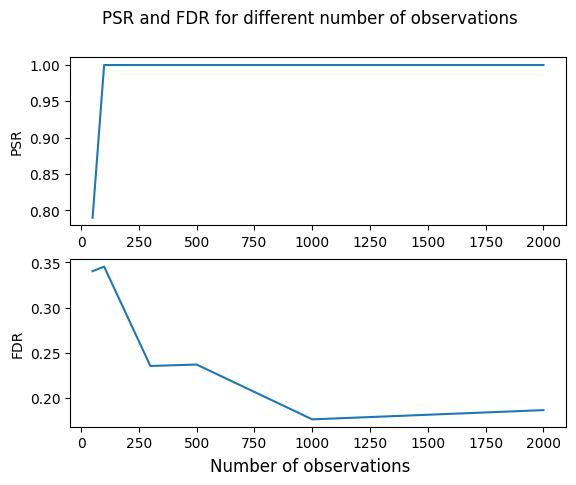

In [250]:
L = 10
ns = [50, 100, 300, 500, 1000, 2000]

psrs = []
fdrs = []

for n in ns: 
    psrs_step = []
    fdrs_step = []
    for i in range(L):
        X, y = generate_data(n, 10, 10)

        Cs = np.arange(0.1, 10, step=0.1)

        lr = LogisticRegressionCV(
            penalty="l1", 
            solver="saga", 
            max_iter=500, 
            Cs=Cs,  
            n_jobs=-1,
        )

        lr.fit(X, y)
        betas_true = np.array(([1] * 10) + ([0] * 10))
        psr, fdr = psr_fdr(betas_true, lr.coef_.ravel(), 0.05)
        
        psrs_step.append(psr)
        fdrs_step.append(fdr)      

    psrs.append(np.nanmean(psrs_step))
    fdrs.append(np.nanmean(fdrs_step))

df_plot = pd.DataFrame({
    "n" : ns,
    "psr": psrs,
    "fdr": fdrs,
})

fig, axes = plt.subplots(nrows=2, ncols=1)

f1 = sns.lineplot(data=df_plot, x="n", y="psr", ax=axes[0])
f1 = sns.lineplot(data=df_plot, x="n", y="fdr", ax=axes[1])
axes[0].set(title="", ylabel="PSR", xlabel="")
axes[1].set(title="", ylabel="FDR", xlabel="")

fig.suptitle("PSR and FDR for different number of observations")
fig.supxlabel("Number of observations")

plt.show()

#### PSR and FDR for different number of irrelevant variables

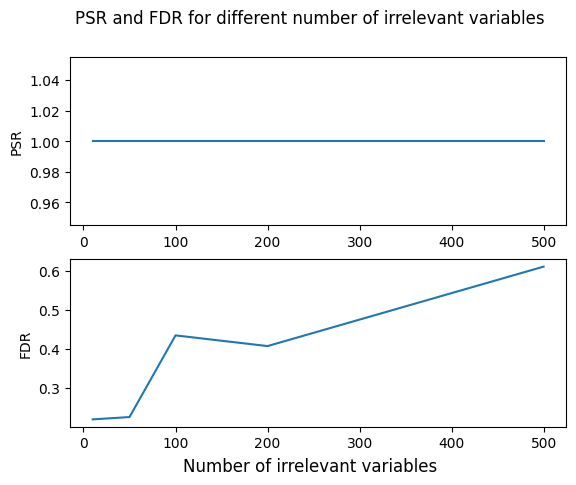

In [251]:
L = 10
number_of_irrelevant = [10, 50, 100, 200, 500]

psrs = []
fdrs = []

for n in number_of_irrelevant:
    psrs_step = []
    fdrs_step = []
    for i in range(L):
        X, y = generate_data(300, 10, n)

        Cs = np.arange(0.1, 10, step=0.1)

        lr = LogisticRegressionCV(
            penalty="l1", 
            solver="saga", 
            max_iter=500, 
            Cs=Cs,  
            n_jobs=-1,
        )

        lr.fit(X, y)

        betas_true = np.array(([1] * 10) + ([0] * n))
        psr, fdr = psr_fdr(betas_true, lr.coef_.ravel(), 0.05)
        
        psrs_step.append(psr)
        fdrs_step.append(fdr)      

    psrs.append(np.nanmean(psrs_step))
    fdrs.append(np.nanmean(fdrs_step))

df_plot = pd.DataFrame({
    "n" : number_of_irrelevant,
    "psr": psrs,
    "fdr": fdrs,
})

fig, axes = plt.subplots(nrows=2, ncols=1)

f1 = sns.lineplot(data=df_plot, x="n", y="psr", ax=axes[0])
f1 = sns.lineplot(data=df_plot, x="n", y="fdr", ax=axes[1])
axes[0].set(title="", ylabel="PSR", xlabel="")
axes[1].set(title="", ylabel="FDR", xlabel="")

fig.suptitle("PSR and FDR for different number of irrelevant variables")
fig.supxlabel("Number of irrelevant variables")

plt.show()

## Analysis of robustness of the logistic regression

In [252]:
def generate_data_other_function(n, n_relevant, n_irrelevant):
    betas = np.array(([1] * n_relevant) + ([0] * n_irrelevant))
    X = np.random.normal(size=(n, n_relevant + n_irrelevant), loc=0, scale=1)
    p = np.exp((-0.5) * (np.sum(betas * X, axis=1) ** 2) ) / np.sqrt(2 * np.pi)
    y = np.random.binomial(n=1, p=p)

    return X, y

#### Average PSR and FDR in 100 calculations

In [253]:
L = 100

psrs = []
fdrs = []

for l in range(L):
    X, y = generate_data_other_function(100, 10, 10)

    Cs = np.arange(0.1, 10, step=0.1)

    lr = LogisticRegressionCV(
        penalty="l1", 
        solver="saga", 
        max_iter=500, 
        Cs=Cs,  
        n_jobs=-1,
    )

    lr.fit(X, y)
    betas_true = np.array(([1] * 10) + ([0] * 10))
    psr, fdr = psr_fdr(betas_true, lr.coef_.ravel(), 0.05)
    psrs.append(psr)
    fdrs.append(fdr)

print(f"Positive Selection Rate: {np.round(np.nanmean(psrs), 3)}")
print(f"False Discovery Rate: {np.round(np.nanmean(fdrs), 3)}")

Positive Selection Rate: 0.066
False Discovery Rate: 0.493


#### PSR and FDR for different sample sizes

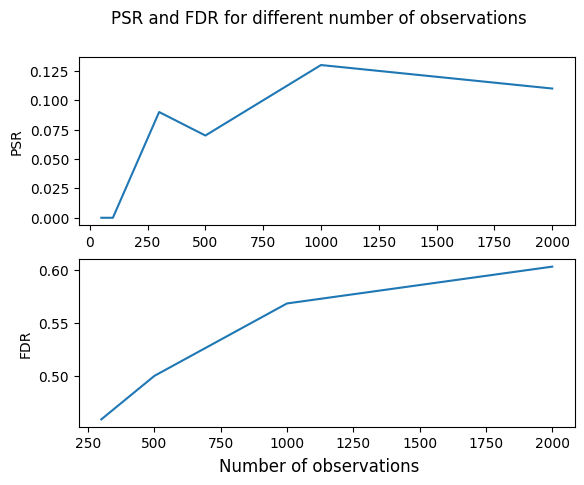

In [254]:
L = 10
ns = [50, 100, 300, 500, 1000, 2000]

psrs = []
fdrs = []

for n in ns: 
    psrs_step = []
    fdrs_step = []
    for i in range(L):
        X, y = generate_data_other_function(n, 10, 10)

        Cs = np.arange(0.1, 10, step=0.1)

        lr = LogisticRegressionCV(
            penalty="l1", 
            solver="saga", 
            max_iter=500, 
            Cs=Cs,  
            n_jobs=-1,
        )

        lr.fit(X, y)
        betas_true = np.array(([1] * 10) + ([0] * 10))
        psr, fdr = psr_fdr(betas_true, lr.coef_.ravel(), 0.05)
        
        psrs_step.append(psr)
        fdrs_step.append(fdr)      

    psrs.append(np.nanmean(psrs_step))
    fdrs.append(np.nanmean(fdrs_step))

df_plot = pd.DataFrame({
    "n" : ns,
    "psr": psrs,
    "fdr": fdrs,
})

fig, axes = plt.subplots(nrows=2, ncols=1)

f1 = sns.lineplot(data=df_plot, x="n", y="psr", ax=axes[0])
f1 = sns.lineplot(data=df_plot, x="n", y="fdr", ax=axes[1])
axes[0].set(title="", ylabel="PSR", xlabel="")
axes[1].set(title="", ylabel="FDR", xlabel="")

fig.suptitle("PSR and FDR for different number of observations")
fig.supxlabel("Number of observations")

plt.show()

#### PSR and FDR for different number of irrelevant variables

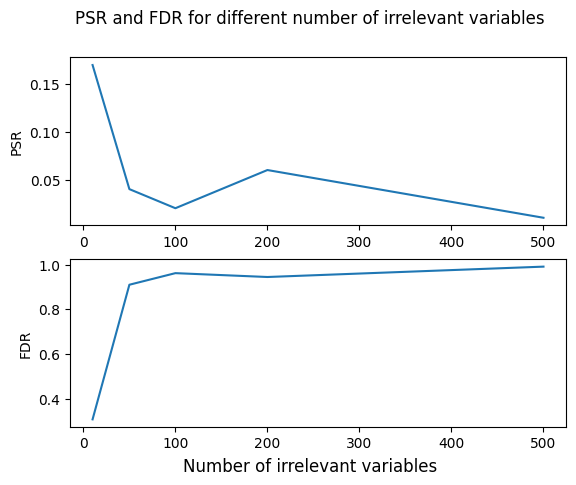

In [255]:
L = 10
number_of_irrelevant = [10, 50, 100, 200, 500]

psrs = []
fdrs = []

for n in number_of_irrelevant:
    psrs_step = []
    fdrs_step = []
    for i in range(L):
        X, y = generate_data_other_function(300, 10, n)

        Cs = np.arange(0.1, 10, step=0.1)

        lr = LogisticRegressionCV(
            penalty="l1", 
            solver="saga", 
            max_iter=500, 
            Cs=Cs,  
            n_jobs=-1,
        )

        lr.fit(X, y)

        betas_true = np.array(([1] * 10) + ([0] * n))
        psr, fdr = psr_fdr(betas_true, lr.coef_.ravel(), 0.05)
        
        psrs_step.append(psr)
        fdrs_step.append(fdr)      

    psrs.append(np.nanmean(psrs_step))
    fdrs.append(np.nanmean(fdrs_step))

df_plot = pd.DataFrame({
    "n" : number_of_irrelevant,
    "psr": psrs,
    "fdr": fdrs,
})

fig, axes = plt.subplots(nrows=2, ncols=1)

f1 = sns.lineplot(data=df_plot, x="n", y="psr", ax=axes[0])
f1 = sns.lineplot(data=df_plot, x="n", y="fdr", ax=axes[1])
axes[0].set(title="", ylabel="PSR", xlabel="")
axes[1].set(title="", ylabel="FDR", xlabel="")

fig.suptitle("PSR and FDR for different number of irrelevant variables")
fig.supxlabel("Number of irrelevant variables")

plt.show()